# Coverage of Confidence Intervals: Exact vs. CLT (Large-Sample) vs. Bootstrap
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\Xbar}{\overline{X}}
\newcommand{\Ybar}{\overline{Y}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
$$

This notebook compares **empirical coverage** of confidence intervals built using:

- **Exact (true sampling distribution)**  
  - Bernoulli mean $p$: **Clopper-Pearson** (Binomial inversion)  
  - Exponential mean $\mu = 1/\lambda$: **Chi-square / Gamma** (exact from $\sum_i X_i$)

- **Large-sample CLT intervals**  
  - Bernoulli mean $p$: Wald $\phat \pm \zalpha\sqrt{\phat(1-\phat)/n}$ 
  - Exponential mean $\mu$: $\Xbar \pm \zalpha\, \Xbar/\sqrt{n}$ (since $\sigma = \mu$)

You can experiment with different sample sizes and see how coverage changes.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import classlib as cl
from scipy.stats import norm, beta, chi2
import time
t0 = time.perf_counter()

%matplotlib inline

cl.nbviz.init(use_tex=True)
colors = cl.nbviz.TOL_BRIGHT
cl.nbviz.configure(figpath="_figures/coverage_exact_vs_clt", savefigs=True, imgfrmt="png")  #change to "...figures/..." to track


## Helpers: Exact and CLT intervals


In [2]:
def ci_bernoulli_clopper_pearson(x: int, n: int, alpha: float = 0.05):
    '''
    Exact (Clopper-Pearson) CI for Bernoulli p based on X ~ Binomial(n, p).
    Uses Beta quantiles.
    '''
    if n <= 0:
        raise ValueError("n must be positive")
    if not (0 <= x <= n):
        raise ValueError("x must be in {0,...,n}")

    lo = 0.0 if x == 0 else beta.ppf(alpha/2, x, n - x + 1)
    hi = 1.0 if x == n else beta.ppf(1 - alpha/2, x + 1, n - x)
    return lo, hi


def ci_bernoulli_wald(phat: float, n: int, alpha: float = 0.05):
    '''
    Large-sample (Wald) CI for p.
    '''
    z = norm.ppf(1 - alpha/2)
    se = np.sqrt(phat * (1 - phat) / n)
    return phat - z * se, phat + z * se


def ci_expon_rate_exact(sum_x: float, n: int, alpha: float = 0.05):
    '''
    Exact CI for exponential rate lambda when X_i iid Exp(rate=lambda).
    If S = sum X_i, then 2*lambda*S ~ chi2(df=2n).

      lambda_L = chi2.ppf(alpha/2, 2n) / (2S)
      lambda_U = chi2.ppf(1-alpha/2, 2n) / (2S)
    '''
    if sum_x <= 0:
        return (np.nan, np.nan)
    df = 2 * n
    lo = chi2.ppf(alpha/2, df) / (2 * sum_x)
    hi = chi2.ppf(1 - alpha/2, df) / (2 * sum_x)
    return lo, hi

def ci_expon_mean_exact(sum_x: float, n: int, alpha: float = 0.05):
    '''
    Exact CI for exponential mean mu = 1/lambda when X_i iid Exp(rate=lambda).

    If S = sum X_i, then 2*lambda*S ~ chi2(df=2n). Since mu = 1/lambda,

      mu_L = 2S / chi2.ppf(1-alpha/2, 2n)
      mu_U = 2S / chi2.ppf(alpha/2, 2n)
    '''
    if sum_x <= 0:
        return (np.nan, np.nan)
    df = 2 * n
    lo = (2 * sum_x) / chi2.ppf(1 - alpha/2, df)
    hi = (2 * sum_x) / chi2.ppf(alpha/2, df)
    return lo, hi


def ci_expon_mean_clt(xbar: float, n: int, alpha: float = 0.05):
    '''
    Large-sample (CLT) CI for the exponential mean mu = E[X].

    For Exp(lambda), Var(X) = mu^2, so SE(Xbar) ≈ mu/sqrt(n).
    We plug in mu_hat = Xbar, giving:

      Xbar +- z * Xbar/sqrt(n)
    '''
    z = norm.ppf(1 - alpha/2)
    se = xbar / np.sqrt(n)
    return xbar - z * se, xbar + z * se




## Simulation engine

We compute coverage for each method by Monte Carlo simulation.

- For Bernoulli: generate $n$ Bernoulli trials, compute $\phat$, and build both intervals.
- For Exponential: generate $n$ $\mathrm{Exp}(\lambda)$ samples, compute $S=\sum_i X_i$ and $\Xbar=S/n$, and build intervals for $\mu=1/\lambda$.



In [3]:
def coverage_bernoulli(p: float, n: int, reps: int = 50_000, alpha: float = 0.05, seed: int = 12345):
    rng_local = np.random.default_rng(seed)
    x = rng_local.binomial(n, p, size=reps)
    phat = x / n

    # Exact
    exact_contains = np.empty(reps, dtype=bool)
    for i in range(reps):
        lo, hi = ci_bernoulli_clopper_pearson(int(x[i]), n, alpha)
        exact_contains[i] = (lo <= p <= hi)

    # CLT (Wald)
    z = norm.ppf(1 - alpha/2)
    se = np.sqrt(phat * (1 - phat) / n)
    lo = phat - z * se
    hi = phat + z * se
    wald_contains = (lo <= p) & (p <= hi)

    # Average interval lengths (exact length approximated by subsampling)
    m = min(5000, reps)
    exact_lengths = np.empty(m)
    for i in range(m):
        a, b = ci_bernoulli_clopper_pearson(int(x[i]), n, alpha)
        exact_lengths[i] = b - a

    return {
        "n": n,
        "p": p,
        "reps": reps,
        "alpha": alpha,
        "coverage_exact": float(exact_contains.mean()),
        "coverage_clt_wald": float(wald_contains.mean()),
        "avg_length_exact": float(exact_lengths.mean()),
        "avg_length_clt_wald": float(np.mean(hi - lo)),
    }

def coverage_exponential(lam: float, n: int, reps: int = 50_000, alpha: float = 0.05, seed: int = 12345):
    '''
    Compare coverage for the exponential mean mu = 1/lambda:

      - Exact CI for mu (chi-square / Gamma pivot based on S = sum X_i)
      - CLT CI for mu using Var(X)=mu^2 and plug-in mu_hat = Xbar
    '''
    rng_local = np.random.default_rng(seed)
    x = rng_local.exponential(scale=1/lam, size=(reps, n))
    s = x.sum(axis=1)
    xbar = s / n

    mu = 1/lam

    # Exact mu CI
    lo_e = np.empty(reps)
    hi_e = np.empty(reps)
    for i in range(reps):
        lo_e[i], hi_e[i] = ci_expon_mean_exact(float(s[i]), n, alpha)
    exact_contains = (lo_e <= mu) & (mu <= hi_e)

    # CLT mu CI (plug-in)
    z = norm.ppf(1 - alpha/2)
    se = xbar / np.sqrt(n)
    lo_m = xbar - z * se
    hi_m = xbar + z * se
    clt_contains = (lo_m <= mu) & (mu <= hi_m)

    return {
        "n": n,
        "lambda": lam,
        "mu": mu,
        "reps": reps,
        "alpha": alpha,
        "coverage_exact_mu": float(exact_contains.mean()),
        "coverage_clt_mu": float(clt_contains.mean()),
        "avg_length_exact_mu": float(np.mean(hi_e - lo_e)),
        "avg_length_clt_mu": float(np.mean(hi_m - lo_m)),
    }

# --- Normal example: exact t CI vs CLT z CI for the mean mu (unknown sigma) ---
def coverage_normal(mu: float, sigma: float, n: int, reps: int = 50_000,
                    alpha: float = 0.05, seed: int = 12345):
    rng_local = np.random.default_rng(seed)
    x = rng_local.normal(loc=mu, scale=sigma, size=(reps, n))
    xbar = x.mean(axis=1)
    s = x.std(axis=1, ddof=1)

    se = s / np.sqrt(n)

    # Exact t CI
    tcrit = stats.t.ppf(1 - alpha/2, df=n - 1)
    lo_t = xbar - tcrit * se
    hi_t = xbar + tcrit * se
    t_contains = (lo_t <= mu) & (mu <= hi_t)

    # CLT (plug-in) z CI
    zcrit = norm.ppf(1 - alpha/2)
    lo_z = xbar - zcrit * se
    hi_z = xbar + zcrit * se
    z_contains = (lo_z <= mu) & (mu <= hi_z)

    return {
        "n": n,
        "mu": mu,
        "sigma": sigma,
        "reps": reps,
        "alpha": alpha,
        "coverage_exact_t": float(t_contains.mean()),
        "coverage_clt_z": float(z_contains.mean()),
        "avg_length_exact_t": float(np.mean(hi_t - lo_t)),
        "avg_length_clt_z": float(np.mean(hi_z - lo_z)),
    }



## Single experiment (quick)

Change the parameters below, run the cell, and inspect coverage.

### Bernoulli distribution

In [4]:
p = 0.30  #probability of success = mean
n = 20  #number of samples
reps = 50_000  #number of replications or experiments
alpha = 0.05  #probability of being wrong

res_b = coverage_bernoulli(p=p, n=n, reps=reps, alpha=alpha, seed=2026)
df_b = pd.DataFrame([res_b])
cl.nbviz.display_latex_df(df_b)

,$n$,$p$,reps,$\alpha$,coverage_exact,coverage_clt_wald,avg_length_exact,avg_length_clt_wald
0,20.000,0.300,50000.000,0.050,0.976,0.948,0.414,0.389


### Exponential distribution

In [5]:
lam = 2.0  #rate = 1/mean
n = 10  #number of samples
reps = 50_000  #number of replications or experiments
alpha = 0.05  #probability of being wrong

res_e = coverage_exponential(lam=lam, n=n, reps=reps, alpha=alpha, seed=2026)
df_e = pd.DataFrame([res_e])
cl.nbviz.display_latex_df(df_e)

,$n$,$\lambda$,$\mu$,reps,$\alpha$,coverage_exact_mu,coverage_clt_mu,avg_length_exact_mu,avg_length_clt_mu
0,10.000,2.000,0.500,50000.000,0.050,0.951,0.903,0.748,0.618



## Coverage vs sample size

Pick a grid of sample sizes, $n$, and compare methods on one plot.


In [6]:
def bernoulli_grid(p: float, ns, reps: int = 30_000, alpha: float = 0.05, seed: int = 12345):
    rows = []
    for i, n in enumerate(ns):
        rows.append(coverage_bernoulli(p=p, n=int(n), reps=reps, alpha=alpha, seed=seed + i))
    return pd.DataFrame(rows)

def exponential_grid(lam: float, ns, reps: int = 30_000, alpha: float = 0.05, seed: int = 12345):
    rows = []
    for i, n in enumerate(ns):
        rows.append(coverage_exponential(lam=lam, n=int(n), reps=reps, alpha=alpha, seed=seed + i))
    return pd.DataFrame(rows)

def normal_grid(mu: float, sigma: float, ns: list[int], reps: int = 50_000,
                alpha: float = 0.05, seed: int = 12345):
    rows = []
    for k, n in enumerate(ns):
        rows.append(
            coverage_normal(mu=mu, sigma=sigma, n=n,
                            reps=reps, alpha=alpha, seed=seed + k)
        )
    return pd.DataFrame(rows)

### Bernoulli distribution

In [7]:
p = 0.30
ns = [5, 10, 15, 20, 30, 50, 100, 200]
reps = 30_000
alpha = 0.05

dfb = bernoulli_grid(p=p, ns=ns, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(dfb)

,$n$,$p$,reps,$\alpha$,coverage_exact,coverage_clt_wald,avg_length_exact,avg_length_clt_wald
0,5.000,0.300,30000.000,0.050,0.997,0.801,0.721,0.651
1,10.000,0.300,30000.000,0.050,0.989,0.843,0.560,0.527
2,15.000,0.300,30000.000,0.050,0.980,0.950,0.470,0.444
3,20.000,0.300,30000.000,0.050,0.976,0.948,0.413,0.389
4,30.000,0.300,30000.000,0.050,0.974,0.953,0.341,0.321
5,50.000,0.300,30000.000,0.050,0.970,0.935,0.264,0.251
6,100.000,0.300,30000.000,0.050,0.962,0.950,0.186,0.178
7,200.000,0.300,30000.000,0.050,0.953,0.942,0.131,0.127


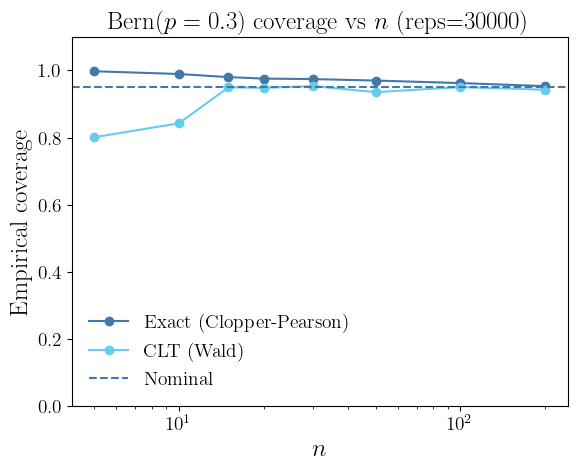

In [8]:
plt.figure()
plt.plot(dfb["n"], dfb["coverage_exact"], marker="o", label="Exact (Clopper-Pearson)")
plt.plot(dfb["n"], dfb["coverage_clt_wald"], marker="o", label="CLT (Wald)")
plt.axhline(1 - dfb["alpha"].iloc[0], linestyle="--", label="Nominal")
plt.xscale("log")
plt.ylim(0, 1.1)
plt.xlabel("$n$")
plt.ylabel("Empirical coverage")
plt.title(rf"Bern($p= {p}$) coverage vs $n$ (reps={reps})")
plt.legend()
cl.nbviz.savefig("bernoulli_coverage_vs_n");

### Exponential distribution

In [9]:
# Exponential grid
lam = 2.0
ns = [2, 3, 5, 10, 20, 30, 50, 100]
reps = 30_000
alpha = 0.05

dfe = exponential_grid(lam=lam, ns=ns, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(dfe)

,$n$,$\lambda$,$\mu$,reps,$\alpha$,coverage_exact_mu,coverage_clt_mu,avg_length_exact_mu,avg_length_clt_mu
0,2.000,2.000,0.500,30000.000,0.050,0.950,0.794,3.938,1.382
1,3.000,2.000,0.500,30000.000,0.050,0.951,0.828,2.215,1.131
2,5.000,2.000,0.500,30000.000,0.050,0.949,0.871,1.297,0.878
3,10.000,2.000,0.500,30000.000,0.050,0.951,0.907,0.750,0.620
4,20.000,2.000,0.500,30000.000,0.050,0.952,0.927,0.482,0.439
5,30.000,2.000,0.500,30000.000,0.050,0.949,0.935,0.381,0.358
6,50.000,2.000,0.500,30000.000,0.050,0.950,0.940,0.288,0.277
7,100.000,2.000,0.500,30000.000,0.050,0.951,0.945,0.200,0.196


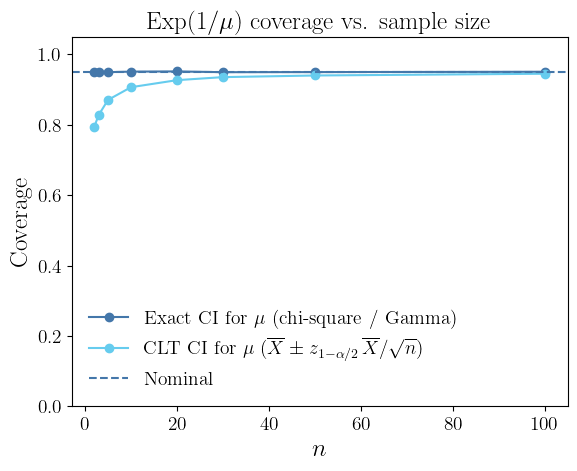

In [10]:
plt.figure()
plt.plot(dfe["n"], dfe["coverage_exact_mu"], marker="o", label="Exact CI for $\mu$ (chi-square / Gamma)")
# plt.plot(dfe["n"], dfe["coverage_clt_mu"], marker="o", label="CLT CI for $\mu$ ($\Xbar \pm \zalpha\, \Xbar/\sqrt{n}$)")
plt.plot(dfe["n"], dfe["coverage_clt_mu"], marker="o", label=r"CLT CI for $\mu$ ($\overline{X} \pm z_{1-\alpha/2}\,\overline{X}/\sqrt{n})$")
plt.axhline(1 - dfe["alpha"].iloc[0], linestyle="--", label="Nominal")
plt.ylim(0, 1.05)
plt.xlabel("$n$")
plt.ylabel("Coverage")
plt.title("Exp($1/\mu$) coverage vs. sample size")
plt.legend()
cl.nbviz.savefig("exponential_coverage_vs_n");

### Normal distribution

In [11]:
mu = 0.0  #true mean
sigma = 1.0  #true standard deviation
ns = [2, 5, 8, 11, 15, 20, 30, 50, 100, 200]
reps = 30_000
alpha = 0.05

dfn = normal_grid(mu=mu, sigma=sigma, ns=ns, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(dfn)

,$n$,$\mu$,sigma,reps,$\alpha$,coverage_exact_t,coverage_clt_z,avg_length_exact_t,avg_length_clt_z
0,2.000,0.000,1.000,30000.000,0.050,0.951,0.699,14.350,2.214
1,5.000,0.000,1.000,30000.000,0.050,0.948,0.874,2.332,1.646
2,8.000,0.000,1.000,30000.000,0.050,0.951,0.910,1.618,1.342
3,11.000,0.000,1.000,30000.000,0.050,0.948,0.919,1.309,1.151
4,15.000,0.000,1.000,30000.000,0.050,0.949,0.929,1.087,0.993
5,20.000,0.000,1.000,30000.000,0.050,0.949,0.932,0.924,0.865
6,30.000,0.000,1.000,30000.000,0.050,0.951,0.942,0.739,0.709
7,50.000,0.000,1.000,30000.000,0.050,0.951,0.945,0.566,0.552
8,100.000,0.000,1.000,30000.000,0.050,0.950,0.948,0.396,0.391
9,200.000,0.000,1.000,30000.000,0.050,0.950,0.949,0.279,0.277


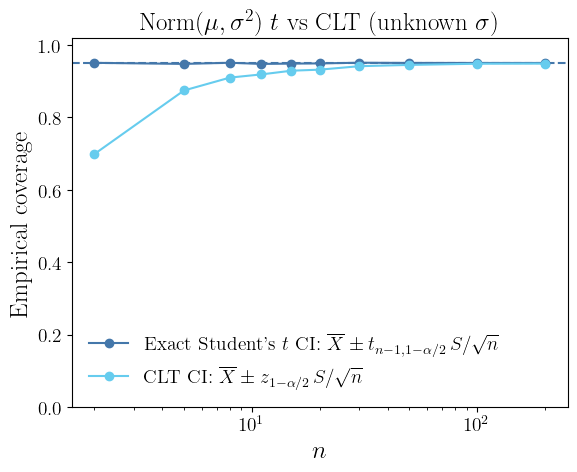

In [12]:
plt.figure()
plt.axhline(1 - alpha, linestyle="--")
plt.plot(dfn["n"], dfn["coverage_exact_t"], marker="o",
         label=r"Exact Student's $t$ CI: $\overline{X} \pm t_{n-1,1-\alpha/2}\,S/\sqrt{n}$")
plt.plot(dfn["n"], dfn["coverage_clt_z"], marker="o",
         label=r"CLT CI: $\overline{X} \pm z_{1-\alpha/2}\,S/\sqrt{n}$")
plt.xscale("log")
plt.ylim(0, 1.02)
plt.xlabel(r"$n$")
plt.ylabel("Empirical coverage")
plt.title(r"Norm$(\mu,\sigma^2)$ $t$ vs CLT (unknown $\sigma$)")
plt.legend()
cl.nbviz.savefig("normal_t_vs_clt_coverage")

Note:  If $\sigma$ is known, then the CLT CI based on $\sigma$ is exact even for small $n$


## Coverage vs proportion for Bernoulli

Scan over a parameter grid at a fixed $n$  with $p \in \{0.05, 0.10, ..., 0.95\}$


In [13]:
def bernoulli_param_scan(ps, n: int, reps: int = 30_000, alpha: float = 0.05, seed: int = 12345):
    rows = []
    for i, p in enumerate(ps):
        rows.append(coverage_bernoulli(p=float(p), n=n, reps=reps, alpha=alpha, seed=seed + i))
    return pd.DataFrame(rows)

ps = np.linspace(0.05, 0.95, 19)
n = 20
reps = 30_000
alpha = 0.05

df_scan = bernoulli_param_scan(ps=ps, n=n, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(df_scan.head())


,$n$,$p$,reps,$\alpha$,coverage_exact,coverage_clt_wald,avg_length_exact,avg_length_clt_wald
0,20.000,0.050,30000.000,0.050,0.984,0.635,0.239,0.145
1,20.000,0.100,30000.000,0.050,0.988,0.879,0.292,0.235
2,20.000,0.150,30000.000,0.050,0.978,0.821,0.333,0.293
3,20.000,0.200,30000.000,0.050,0.978,0.920,0.367,0.335
4,20.000,0.250,30000.000,0.050,0.962,0.895,0.393,0.366


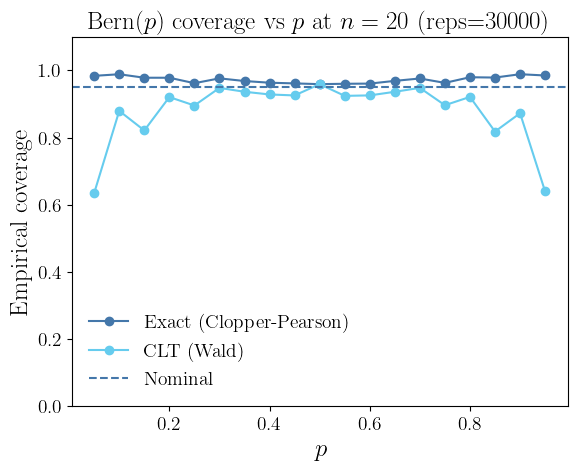

In [14]:
plt.figure()
plt.plot(df_scan["p"], df_scan["coverage_exact"], marker="o", label="Exact (Clopper-Pearson)")
plt.plot(df_scan["p"], df_scan["coverage_clt_wald"], marker="o", label="CLT (Wald)")
plt.axhline(1 - df_scan["alpha"].iloc[0], linestyle="--", label="Nominal")
plt.ylim(0, 1.1)
plt.xlabel("$p$")
plt.ylabel("Empirical coverage")
plt.title(f"Bern$(p)$ coverage vs $p$ at $n={n}$ (reps={reps})")
plt.legend()
cl.nbviz.savefig("bernoulli_coverage_vs_p");

## Bootstrap Confidence Intervals
When the distributional or sample size assumptions do not merit the classical confidence intervals, we can turn to the _bootstrap_

### Skewed population
First we generate a simulated sample with known mean

In [28]:

import numpy as np
rng = np.random.default_rng()

def generate_population(N, kind="exponential"):
    """
    Generate a finite population of size N and return
    the population along with its true mean and median.
    """

    if kind == "exponential":
        # Skewed, mean = 1
        population = rng.exponential(scale=1.0, size=N)

    elif kind == "normal":
        # Symmetric
        population = rng.normal(loc=0.0, scale=1.0, size=N)

    elif kind == "mixture_normal":
        # Mostly N(0,1), with some large-variance outliers
        mix = rng.choice([0, 1], size=N, p=[0.9, 0.1])
        population = rng.normal(loc=0.0, scale=1.0, size=N)
        population[mix == 1] = rng.normal(loc=0.0, scale=5.0, size=(mix == 1).sum())

    elif kind == "t_heavy":
        # Heavy-tailed symmetric distribution
        population = rng.standard_t(df=3, size=N)

    else:
        raise ValueError(f"Unknown population kind: {kind}")

    true_mean = np.mean(population)
    true_med  = np.median(population)

    return population, true_mean, true_med

N=10_001 #population size
population, true_mean, true_med = generate_population(N, kind="exponential")
print(true_mean)

1.0117119573643516


### Small sample
Next we take a small sample

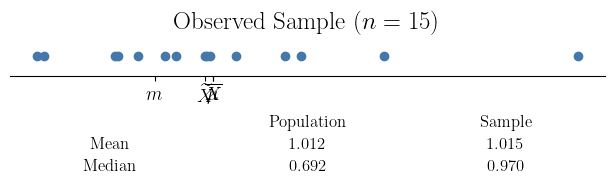

In [30]:
n = 15
sample = rng.choice(population, size=n, replace=False)  #take 

fig = plt.figure(figsize=(7, 1.8))

# ---- plot axes (top) ----
ax = fig.add_axes([0.1, 0.55, 0.85, 0.22])

ax.plot(sample, np.zeros_like(sample), 'o')

mu = true_mean
m_true = true_med
xbar = np.mean(sample)
xmed = np.median(sample)

ax.set_xticks([mu, xbar, m_true, xmed])
ax.set_xticklabels([r"$\mu$", r"$\overline{X}$", r"$m$", r"$\widetilde{X}$"])

ax.set_ylim(-0.05, 0.05)
ax.set_yticks([])

ax.set_title(rf"Observed Sample ($n={n}$)", pad=6)

for side in ["left", "right", "top"]:
    ax.spines[side].set_visible(False)

# ---- table axes (bottom) ----
ax_tbl = fig.add_axes([0.1, 0.02, 0.85, 0.30])
ax_tbl.axis("off")

table = ax_tbl.table(
    cellText=[
        ["Mean", f"{true_mean:.3f}", f"{xbar:.3f}"],
        ["Median", f"{true_med:.3f}", f"{xmed:.3f}"],
    ],
    colLabels=["", "Population", "Sample"],
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.0, 1.3)

for cell in table.get_celld().values():
    cell.set_linewidth(0)
    cell.set_edgecolor("none")

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")

plt.show()

### Classical CLT confidence interval for the mean

In [31]:
alpha = 0.05
z=norm.ppf(1 - alpha/2)

xbar = np.mean(sample)
s = np.std(sample, ddof=1)

ci_clt = (
    xbar - z * s / np.sqrt(n),
    xbar + z * s / np.sqrt(n)
)

print(rf"A classical CLT confidence interval for the mean = ({ci_clt[0]:.2f},{ci_clt[1]:.2f})")

A classical CLT confidence interval for the mean = (0.63,1.40)


### Bootstrap percentile confidence interval

In [32]:
B = 10_000
boot_means = np.empty(B)

for b in range(B):
    boot_sample = rng.choice(sample, size=n, replace=True)
    boot_means[b] = np.mean(boot_sample)

ci_boot = np.percentile(boot_means, [2.5, 97.5])
print(rf"A bootstrap confidence interval for the mean = ({ci_boot[0]:.2f},{ci_boot[1]:.2f})")

A bootstrap confidence interval for the mean = (0.68,1.40)


In [33]:
M = 1000      # number of repeated samples (increase to 1000+ if you want)
B = 2000     # bootstrap reps per sample (1000-5000 is typical)

methods = ["CLT", "Bootstrap (percentile)", "Bootstrap-t"]
covers = {m: 0 for m in methods}
lengths = {m: [] for m in methods}

for _ in range(M):
    sample = rng.choice(population, size=n, replace=False)

    xbar = np.mean(sample)
    s = np.std(sample, ddof=1)
    se = s / np.sqrt(n)

    # --- CLT CI ---
    ci_clt = (xbar - z * se, xbar + z * se)
    covers["CLT"] += (ci_clt[0] <= true_mean <= ci_clt[1])
    lengths["CLT"].append(ci_clt[1] - ci_clt[0])

    # --- Bootstrap reps (shared) ---
    boot_means = np.empty(B)
    boot_ses = np.empty(B)

    for b in range(B):
        boot = rng.choice(sample, size=n, replace=True)
        boot_means[b] = np.mean(boot)
        boot_ses[b] = np.std(boot, ddof=1) / np.sqrt(n)

    # --- Percentile bootstrap CI ---
    lo_p, hi_p = np.percentile(boot_means, [100*alpha/2, 100*(1-alpha/2)])
    ci_pct = (lo_p, hi_p)
    covers["Bootstrap (percentile)"] += (ci_pct[0] <= true_mean <= ci_pct[1])
    lengths["Bootstrap (percentile)"].append(ci_pct[1] - ci_pct[0])

    # --- Bootstrap-t CI ---
    tstars = (boot_means - xbar) / boot_ses
    q_hi, q_lo = np.quantile(tstars, [1 - alpha/2, alpha/2])  # note order
    ci_bt = (xbar - q_hi * se, xbar - q_lo * se)

    covers["Bootstrap-t"] += (ci_bt[0] <= true_mean <= ci_bt[1])
    lengths["Bootstrap-t"].append(ci_bt[1] - ci_bt[0])

results = pd.DataFrame(
    {
        "Coverage": [covers[m] / M for m in methods],
        "Avg length": [np.mean(lengths[m]) for m in methods],
    },
    index=methods
)

results_fmt = results.copy()
results_fmt["Coverage"] = (100 * results_fmt["Coverage"]).map(lambda x: f"{x:.1f}%")
results_fmt["Avg length"] = results_fmt["Avg length"].map(lambda x: f"{x:.3f}")
results_fmt

results

,Coverage,Avg length
CLT,0.895,0.972440
Bootstrap (percentile),0.887,0.928170
Bootstrap-t,0.952,1.310768


In [20]:
elapsed = time.perf_counter() - t0
mins, secs = divmod(elapsed, 60)
print(f"Total runtime: {int(mins)} min {secs:4.1f} sec")

Total runtime: 1 min 46.8 sec
